In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

In [2]:
%matplotlib inline

In [3]:
data = np.loadtxt('../data/halo_particles/Bolshoi/halo_003438.dat', delimiter=',')

def downsample(data, n_select=200):
    r_data = np.sqrt(data[:,0]**2 + data[:,1]**2 + data[:,2]**2)
    r_max = r_data.max()
    r_data = r_data/r_max
    n_points = len(data)
    id_list = np.arange(n_points)
    for i in range(5):
        id_list = np.random.permutation(id_list)
        
    sample_id = np.random.choice(id_list, n_select+1)
    r_norm = r_data[sample_id]
    r_norm.sort()
    r_norm = np.delete(r_norm, 0) # just in case
    m_norm = np.linspace(1.0/n_select, 1.0, n_select)
    return r_norm, m_norm

In [78]:
def get_cov_matrix(data, n_select=200, n_iter=20):
    all_r_n = np.zeros((n_iter, n_select))
    all_m_n = np.zeros((n_iter, n_select))
    for i in range(n_iter):
        r_n, m_n = downsample(data, n_select=n_select)
        #plt.plot(np.log10(r_n), np.log10(m_n))
        all_r_n[i,:] = np.log10(r_n[:])
        all_m_n[i,:] = np.log10(m_n[:])
    r_av = np.average(all_r_n, axis=0)
    all_m_n_interpolated = np.zeros((n_iter, n_select))
    for i in range(n_iter):
        r_n = all_r_n[i,:]
        m_n = all_m_n[i,:]
        f = scipy.interpolate.interp1d(r_n, m_n, fill_value=None, bounds_error=False)
        all_m_n_interpolated[i,:] = f(r_av)
    m_av = np.average(all_m_n_interpolated, axis=0)
    cov_matrix = np.cov(all_m_n_interpolated, rowvar=False)
    #plt.plot(r_av, m_av)
    return cov_matrix

In [114]:
cov_matrix_200 = get_cov_matrix(data, n_select=200, n_iter=80)

In [115]:
cov_matrix_500 = get_cov_matrix(data, n_select=500, n_iter=80)

In [116]:
cov_matrix_1000 = get_cov_matrix(data, n_select=1000, n_iter=80)

In [126]:
cov_matrix_2000 = get_cov_matrix(data, n_select=2000, n_iter=90)

In [193]:
cov_matrix_4000 = get_cov_matrix(data, n_select=4000, n_iter=90)

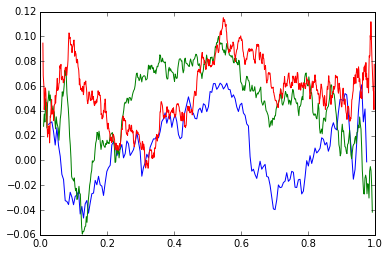

In [118]:
x = np.linspace(1.0/200,1.0-1.0/200,200)
plt.plot(x, np.log10(np.sqrt(6.0) * np.sqrt(x/(1.0-x)) * np.sqrt(200.0) * np.sqrt((cov_matrix_200.diagonal()))))

x = np.linspace(1.0/500,1.0-1.0/500,500)
plt.plot(x, np.log10(np.sqrt(6.0) * np.sqrt(x/(1.0-x))* np.sqrt(500.0) * np.sqrt((cov_matrix_500.diagonal()))))

x = np.linspace(1.0/1000,1-1.0/4000,1000)
plt.plot(x, np.log10(np.sqrt(6.0) * np.sqrt(x/(1.0-x)) * np.sqrt(1000.0) * np.sqrt((cov_matrix_1000.diagonal()))))

In [124]:
grid_x, grid_y = np.mgrid[1.0/1000:1-1.0/1000:1000j, 1/1000.0:1-1.0/1000.0:1000j]
new_cov_matrix = 6 * cov_matrix_1000 * 1000   * np.sqrt(grid_x/(1.0-grid_x)) * np.sqrt(grid_y/(1.0-grid_y))
test_cov_matrix = (1.0/6.0) * (1.0/1000.0)  * np.sqrt((1.0-grid_x)/(grid_x)) * np.sqrt((1.0-grid_y)/grid_y)


def clean_matrix(cov_m):
    ii = np.isnan(cov_m)
    cov_m[ii] = 1E-4
    ii = np.isinf(cov_m)
    cov_m[ii] = 1.0
    return cov_m

In [120]:
cov_matrix_200  = clean_matrix(cov_matrix_200)
cov_inv_200  = np.linalg.pinv(np.matrix(cov_matrix_200))

In [121]:
cov_matrix_500 = clean_matrix(cov_matrix_500)
cov_inv_500  = np.linalg.pinv(np.matrix(cov_matrix_500))

In [16]:
cov_matrix_1000 = clean_matrix(cov_matrix_1000)
cov_inv_1000  = np.linalg.pinv(np.matrix(cov_matrix_1000))

In [128]:
cov_matrix_2000 = clean_matrix(cov_matrix_2000)
cov_inv_2000  = np.linalg.pinv(np.matrix(cov_matrix_2000))

In [194]:
cov_matrix_4000 = clean_matrix(cov_matrix_4000)
cov_inv_4000  = np.linalg.pinv(np.matrix(cov_matrix_4000))

In [247]:
def test_covariance(cov_inv, n_points=4000, factor=3.0):
    n_vals = 20
    mean_value_list = np.linspace(-0.5,0.5,n_vals)

    exact_full = np.zeros(n_vals)
    approx_diagonal = np.zeros(n_vals)
    for i in range(n_vals):
        x = 1E-7 * np.random.random(n_points) + mean_value_list[i]
        y = np.linspace(1.0/n_points,1-1.0/n_points,n_points)
    
        a = np.matmul(x, cov_inv)
        b = np.matmul(a, x.T)
        exact_full[i] = b
    
        sigma2 = ((1.0-y) / y) * (1.0/10.0) # sirve para 200
        sigma2 = ((1.0-y) / y) * (2.0/3.0) # sirve para 1000
        sigma2 = ((1.0-y) / y) * (12.0/4.0) # sirve para 4000
        sigma2 = ((1.0-y) / y) * factor
        #sigma2 = factor
        b_new = np.sum(x * x  /sigma2)
        approx_diagonal[i] = b_new
    
    plt.plot(mean_value_list, exact_full)
    plt.plot(mean_value_list, approx_diagonal)

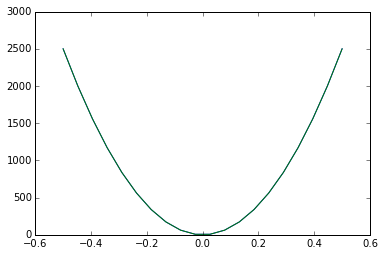

In [258]:
test_covariance(cov_inv_200, n_points=200, factor=0.02)

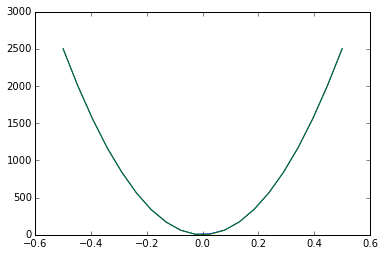

In [233]:
test_covariance(cov_inv_500, n_points=500, factor=0.29)

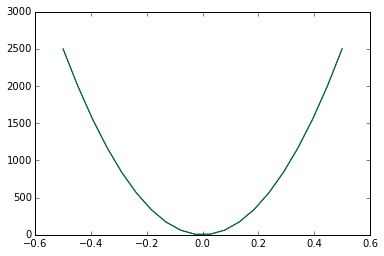

In [232]:
test_covariance(cov_inv_1000, n_points=1000, factor=0.650)

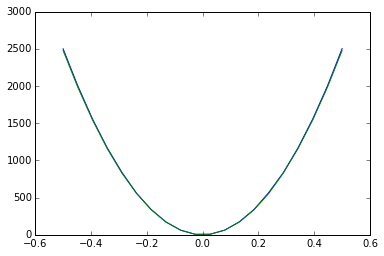

In [228]:
test_covariance(cov_inv_2000, n_points=2000, factor=1.45)

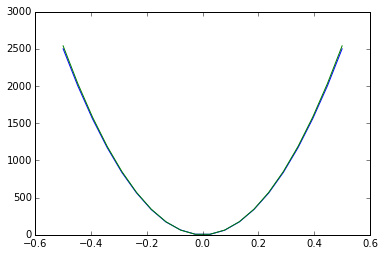

In [220]:
test_covariance(cov_inv_4000, n_points=4000, factor=3.1)

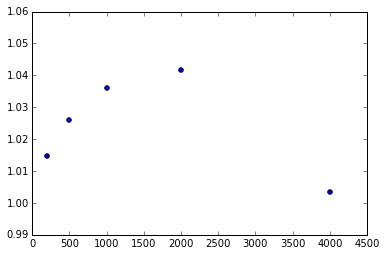

In [246]:
nn = np.array([200,500,1000,2000, 4000])
ff = np.array([0.10, 0.29, 0.65, 1.45, 3.1])
plt.scatter(nn, ff/(nn/1.5E3)**1.15)

In [168]:
plt.imshow(np.log10(np.fabs(cov_inv_test.T)))

NameError: name 'cov_inv_test' is not defined

In [ ]:
plt.plot(new_cov_matrix.diagonal())

In [ ]:
plt.plot(new_cov_matrix[2000,:])